<a href="https://colab.research.google.com/github/Yet-nde/CMM500-CODES/blob/main/experiments_suboptimal_no_session_id_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Reset potentially conflicting variables
for _name in ['X','y','X_train','X_val','X_test','y_train','y_val','y_test','df', 'df_2012','session_cols']:
    if _name in globals():
        del globals()[_name]

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, time, shap

#preprocessing & modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_score,recall_score, f1_score, confusion_matrix, accuracy_score, precision_recall_curve,average_precision_score, roc_curve,auc)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline

#visualisation
%matplotlib inline
sns.set(style="whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = "/content/drive/MyDrive/2012dataset"

In [ ]:
file_paths={
    'Sat':f'{folder_path}/TestbedSatJun12Flows.csv',
    'Sun':f'{folder_path}/TestbedSunJun13Flows.csv',
    'Mon':f'{folder_path}/TestbedMonJun14Flows.csv',
    'Tue':f'{folder_path}/TestbedTueJun15Flows.csv',
    'Wed':f'{folder_path}/TestbedWedJun16Flows.csv',
    'Thu':f'{folder_path}/TestbedThuJun17Flows.csv'
} #dictionary
frames=[]
for day,path in file_paths.items():
    df_2012=pd.read_csv(path)
    df_2012['day']=day
    frames.append(df_2012)

df=pd.concat(frames,ignore_index=True)

In [ ]:
session_cols=['totalSourceBytes','totalDestinationBytes','totalSourcePackets','totalDestinationPackets','direction','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription','protocolName','sourcePort','destinationPort'] #drop time because it does not help the model according to SHAP
                                                                                    #analysis performed and over 83% are zero duration sessions
df=df[session_cols+['Label']]
df=df.copy()

In [ ]:
#packet ratio
df['packet_ratio']=df['totalSourcePackets']/df['totalDestinationPackets'].replace(0,np.nan)
df['packet_ratio']=df['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
df['byte_ratio']=df['totalSourceBytes']/df['totalDestinationBytes'].replace(0,np.nan)
df['byte_ratio']=df['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
df['avg_packet_size_src']=df['totalSourceBytes']/df['totalSourcePackets'].replace(0,np.nan)
df['avg_packet_size_src']=df['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
df['avg_packet_size_dst']=df['totalDestinationBytes']/df['totalDestinationPackets'].replace(0,np.nan)
df['avg_packet_size_dst']=df['avg_packet_size_dst'].fillna(0).clip(upper=1500)

In [ ]:
cat_cols=['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
label_encoders = {}
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")
    le = LabelEncoder()
    df[ col] = le.fit_transform(df[col])
    label_encoders[col] = le

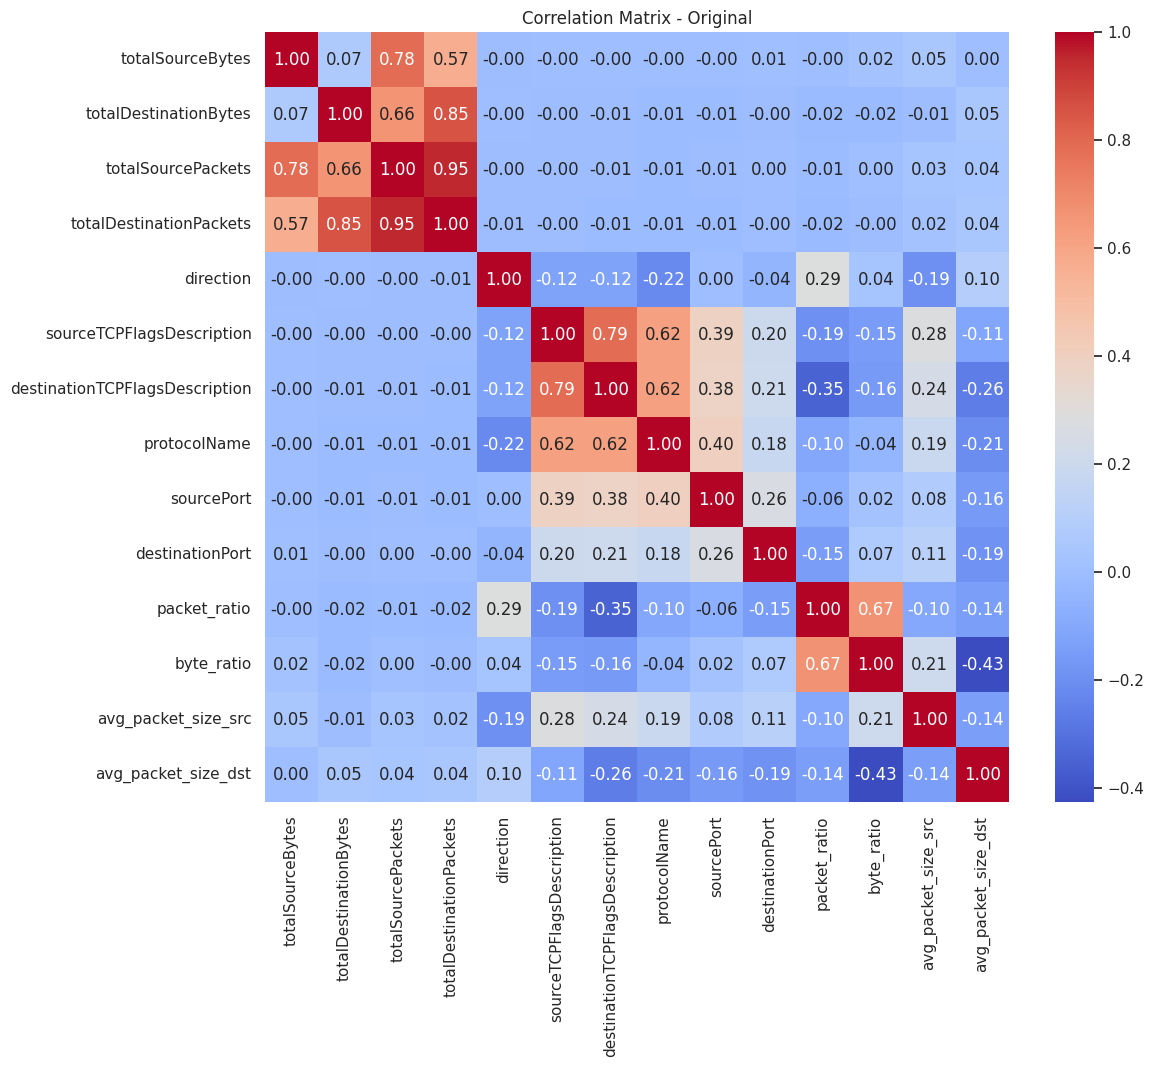

In [ ]:
# Correlation matrix on original columns
numeric_cols = df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Original")
plt.show()

In [ ]:
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation above threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
    return df_reduced

In [ ]:
df_numeric = df.select_dtypes(include=np.number)
df_reduced = drop_highly_correlated(df_numeric)
df_model = pd.concat([df_reduced, df["Label"]], axis=1)

Dropped 1 columns due to high correlation: ['totalDestinationPackets']


In [ ]:
X = df_model.drop("Label", axis=1)
y = df_model["Label"].map({"Normal": 0, "Attack": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 1657325
Testing samples: 414332



Baseline RF Evaluation on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.99      0.99      0.99     13782

    accuracy                           1.00    414332
   macro avg       0.99      1.00      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9996
Average Precision: 0.9985
Confusion Matrix:
[[400360    190]
 [   106  13676]]

Weighted RF Evaluation on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    400550
           1       0.97      1.00      0.98     13782

    accuracy                           1.00    414332
   macro avg       0.99      1.00      0.99    414332
weighted avg       1.00      1.00      1.00    414332

AUC: 0.9998
Average Precision: 0.9982
Confusion Matrix:
[[400156    394]
 [    52  13730]]

SMOTE + RF Evaluation on Test Set:
              precision    recall  f1-score   support


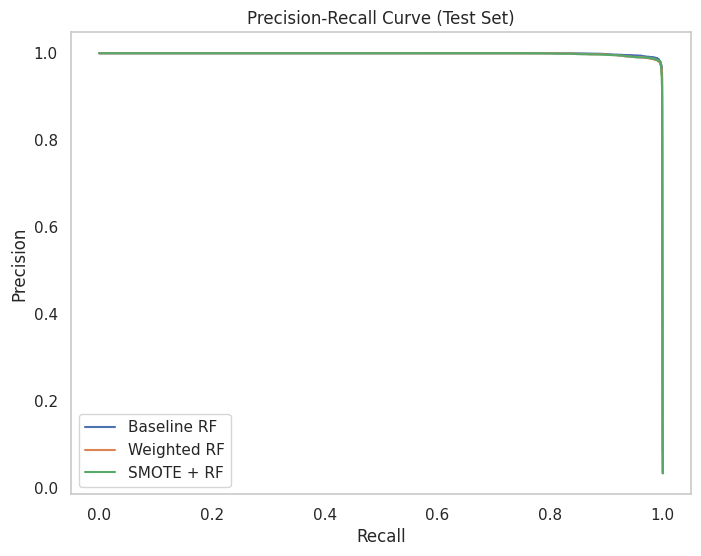

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Evaluation on Test Set:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    return precision, recall

# Define models
rf_params = {'n_estimators': 50, 'max_depth': 15, 'n_jobs': -1, 'random_state': 42}
models = {
    "Baseline RF": RandomForestClassifier(**rf_params),
    "Weighted RF": RandomForestClassifier(class_weight='balanced', **rf_params),
    "SMOTE + RF": Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(**rf_params))
    ])
}

# Fit and evaluate
plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)  # SMOTE only applies inside pipeline
    precision, recall = evaluate_model(name, model, X_test, y_test)
    plt.plot(recall, precision, label=name)

plt.title("Precision-Recall Curve (Test Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def compare_models_cv(models, X, y, scoring=None, cv=5):
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = {}
    for name, model in models.items():
        scores = cross_validate(model, X, y, scoring=scoring, cv=cv)
        results[name] = {metric: round(scores[f'test_{metric}'].mean(), 4) for metric in scoring}
    return pd.DataFrame(results).T

cv_results = compare_models_cv(models, X, y)
print("\nCross-Validation Summary:")
display(cv_results)




📋 Cross-Validation Summary:


,accuracy,precision,recall,f1,roc_auc
Baseline RF,0.9925,0.9154,0.8866,0.8889,0.9898
Weighted RF,0.9911,0.9120,0.8469,0.8594,0.9869
SMOTE + RF,0.9906,0.8375,0.9208,0.8690,0.9935


from matplotlib import pyplot as plt
_df_0['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='f1', y='roc_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='accuracy', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='precision', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='recall', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='f1', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)